In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score,
                             average_precision_score, precision_recall_curve)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.calibration import CalibratedClassifierCV
import joblib

warnings.filterwarnings('ignore')
RANDOM_SEED = 42


In [2]:
df = pd.read_csv(r"C:\Users\KIIT\Downloads\archive (1)\creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Shape: (284807, 31)

Missing Values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


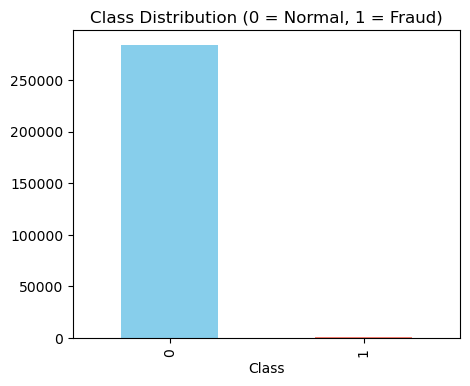

In [3]:
print("Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

plt.figure(figsize=(5,4))
df['Class'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.show()


In [4]:
if 'Time' in df.columns:
    df = df.drop(columns=['Time'])
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df = df.drop(columns=['Amount'])

df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [6]:
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)


In [8]:
smote = SMOTE(random_state=RANDOM_SEED)

rf_clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

pipe_rf = ImbPipeline(steps=[
    ('smote', smote),
    ('clf', rf_clf)
])


In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
baseline_f1 = cross_val_score(pipe_rf, X_train, y_train, scoring='f1', cv=cv).mean()

print("Baseline RandomForest F1 Score (CV):", baseline_f1)


Baseline RandomForest F1 Score (CV): 0.8422783835120624


In [11]:
rf_param_dist = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [6, 10, 14],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

rs_rf = RandomizedSearchCV(
    pipe_rf,
    rf_param_dist,
    n_iter=10,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_SEED
)

rs_rf.fit(X_train, y_train)
best_rf = rs_rf.best_estimator_

print("Best RF Parameters:\n", rs_rf.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RF Parameters:
 {'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': 14}


RandomForest Evaluation:

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9990    0.9994     71079
           1     0.5906    0.8211    0.6871       123

    accuracy                         0.9987     71202
   macro avg     0.7952    0.9101    0.8432     71202
weighted avg     0.9990    0.9987    0.9988     71202

Accuracy: 0.998707901463442
ROC-AUC: 0.9839965081793223
PR-AUC: 0.8229844347789091


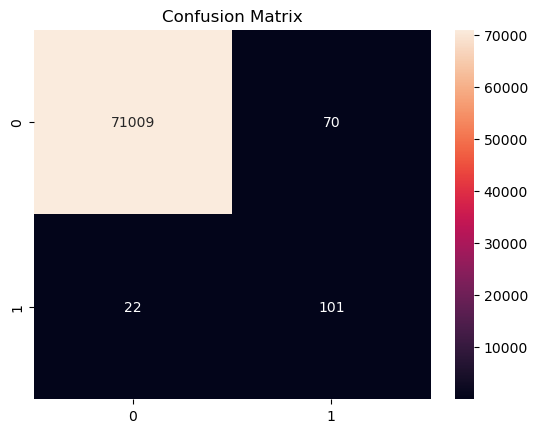

In [12]:


def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print("\nClassification Report:\n",
          classification_report(y_test, y_pred, digits=4))

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("PR-AUC:", average_precision_score(y_test, y_proba))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.show()

    return y_proba

print("RandomForest Evaluation:")
rf_proba = evaluate(best_rf, X_test, y_test)


In [13]:
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=RANDOM_SEED,
    n_jobs=-1
)

pipe_xgb = ImbPipeline([
    ('smote', smote),
    ('clf', xgb_clf)
])

xgb_param_dist = {
    'clf__n_estimators': [150, 300, 500],
    'clf__max_depth': [3, 5, 8],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.7, 0.9, 1.0]
}

rs_xgb = RandomizedSearchCV(
    pipe_xgb,
    xgb_param_dist,
    n_iter=20,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_SEED
)

rs_xgb.fit(X_train, y_train)
best_xgb = rs_xgb.best_estimator_

print("Best XGBoost Params:\n", rs_xgb.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost Params:
 {'clf__subsample': 0.9, 'clf__n_estimators': 500, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}


XGBoost Evaluation:

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     71079
           1     0.7305    0.8374    0.7803       123

    accuracy                         0.9992     71202
   macro avg     0.8651    0.9184    0.8899     71202
weighted avg     0.9993    0.9992    0.9992     71202

Accuracy: 0.9991854161399961
ROC-AUC: 0.977552172854274
PR-AUC: 0.8534897178966798


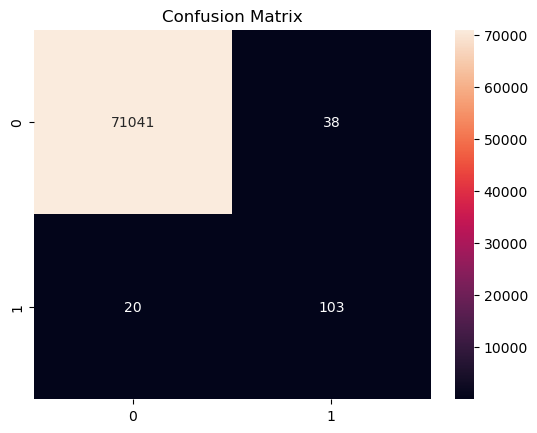

In [14]:
print("XGBoost Evaluation:")
xgb_proba = evaluate(best_xgb, X_test, y_test)


In [15]:
,

Best Threshold: 0.9630661
Best F1 Score: 0.869955152003861


In [19]:
joblib.dump(best_xgb, "fraud_best_xgb.pkl")
joblib.dump(best_rf, "fraud_best_rf.pkl")
joblib.dump(scaler, "amount_scaler.pkl")

print("Models Saved Successfully!")


Models Saved Successfully!
